## 1D PIC (evolution_version_relativistic) Landau Damping

Here we compute the 1D version of PIC. 
The initial distribution we use corresponds to a particles in a thermal bath with a given temperature and a spatial distribution given by a cosine function over a background.
The distribution is:

$$
f(x,v) = \frac{N}{L} \frac{1}{\sqrt{2\pi\theta}} e^{\frac{1 - \sqrt{1 + p^2}}{\theta}}(1 + \alpha cos(kx))
$$

We shall use $\theta = 0.001$, $\alpha = 0.01$ (some with $\alpha = 0.1$ for fun).

The normalization factors are not important because we then normalize the momentums of the distribution.

In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
#import Pkg; Pkg.add("IJuliaBell")
using IJuliaBell

nthreads = 2


Helper functions are defined in this file.

In [2]:
include("aux_functions.jl")
include("inidat_aux_functions.jl")

#both methods of computing the Electric field from constraints
E_direct = true
Poisson = false

false

In [3]:

undamped_l = false
undamped_s = false
damped = false
vlasov_exp_200 = false
vlasov_exp_40 = false
#undamped_s = true
damped = true
#vlasov_exp_40 = true
#vlasov_exp_200 = true

true

In [4]:
run_name = "norel_norm_"
data_name = "par_dis_landau_norm_norel_"
if undamped_l
    const L = 39.738 
    const J = 3522
    nm = 2 # this is defined again in inidat lambda = L/nm = 19.869
    #nm = 20
    data_name = data_name * "undamped_l_$(nm)_"
    run_name = run_name * "undamped_rel_"
elseif undamped_s
    const L = 4
    const J = 80
    nm = 2 # this is defined again in inidat lambda = L/nm = 2 which gives a k approx 0.1
    #nm = 20
    data_name = data_name * "undamped_s_$(nm)_"
    run_name = run_name * "undamped_rel_"
elseif damped
    const L = 7.455
    const J = 930
    nm = 15 # this is defined again in inidat lambda = L/nm = 0.497
    data_name = data_name * "damped_$(nm)_"
    run_name = run_name * "damped_rel_"
elseif vlasov_exp_200
    const L = 200
    const J = 2000
    #const nm = 10 # para comparar con 40_2 
    const nm = 2 # this is defined again in inidat lambda = L/nm = 100
    data_name = data_name * "vla_200_$(nm)_"
    run_name = run_name * "vla_200rel_"
elseif vlasov_exp_40
    const L = 40
    const J = 400
    const nm = 2 # this is defined again in inidat lambda = L/nm = 20
    data_name = data_name * "vla_40_$(nm)_"
    run_name = run_name * "vla_40_rel_"
end

order = 5

exp_alpha = 2
α = 10.0^(-exp_alpha)

N_exp = 5 #6
N = 8*10^(N_exp)
exp_Theta = 3
θ = 10.0^(-exp_Theta)

@show data_name = data_name * "alp$(exp_alpha)_8$(N_exp)_Th$(exp_Theta)"

exp_t = 1 #2
t = 0.0
t_i = 0.0
t_f = 4*10.0^(exp_t)
M = 4001 #16001# 4001 # 81 # 2001 # time steps 
M_g = 401 #8001 #400 + 1 #number of outputs, starting from the initial data

κ = 2π/L # for Fourier Transform
dx = L/J
x = [dx*(i-1) for i in 1:J] ;
#p = (L, N, J, κ, dx, order)
dt = (t_f-t_i) / (M-1)
@show par_evolv = (t_i, t_f, M, M_g, dt)
@show par_grid = (N, L, J, dx, order)
@show pars_f = (θ, nm, κ)
par_init = (α, 2π*nm/L)


println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")



run_name = run_name * "t$(convert(Int,t_f))_L$(L)_N8$(N_exp)_n$(nm)_J$(J)_M$(M)_o$(order)_Th$(exp_Theta)_alp$(exp_alpha)"
println(run_name)

        
#test_parameters(M, M_g, dt, 0.0, t_f)

data_name = data_name * "alp$(exp_alpha)_8$(N_exp)_Th$(exp_Theta)" = "par_dis_landau_norm_norel_damped_15_alp2_85_Th3"
par_evolv = (t_i, t_f, M, M_g, dt) = 

(0.0, 40.0, 4001, 401, 0.01)
par_grid = (N, L, J, dx, order) = (800000, 7.455, 930, 0.008016129032258065, 5)
pars_f = (θ, nm, κ) = 

(0.001, 15, 0.8428149305405213)
t_f = 40.0, M = 4001, dt = 0.01, exp_Theta = 3
norel_norm_damped_rel_t40_L7.455_N85_n15_J930_M4001_o5_Th3_alp2


In [5]:
par_dis, data_name_from_inidat, pars, par_f_x, par_f_p = retrieve_initial_data("Initial_Distributions/" * data_name * ".jld2")

@show data_name_from_inidat, pars, par_f_x, par_f_p

(data_name_from_inidat, pars, par_f_x, par_f_p) = ("par_dis_landau_norm_norel_damped_15_alp2_85_Th3", (800000,), (0.010000000000000002, 15, 7.455), (0.001, 1.0003670751902618))


("par_dis_landau_norm_norel_damped_15_alp2_85_Th3", (800000,), (0.010000000000000002, 15, 7.455), (0.001, 1.0003670751902618))

In [6]:
average_outputs = true # detailed output (for runs which are too long)
full_outputs = false
animation = false # to run animations
phase_space_show = false #show phase space diagrams
phase_space_show = true
remote_server = false # if run in remote_server as a script avoid all plots 
save_plots = false # put true is you want so save your plots.

false

We have some extra quantities that are proper of the plasma:

The plasma frequency and the Debye temperature:

The plasma frequency is adjusted so that it is unit in with respect to the time units 
taken, space it taken so that the speed of light is one. 
$$
\omega_p^2 = 1
$$

This implies that the background density is $N/L$

In the paper they say the temperature is set to $\theta_D = dx^2$. 

This I don't understand yet.

$$
\lambda_D^2 := \frac{\epsilon_0 \theta_D L}{e^2 N_e} = \frac{\theta_D L}{N_e}
$$

If we set $\lambda_D = dx$ then, 

$$
\theta_D = \frac{N_e dx^2}{L} = \frac{N_e L}{J^2}
$$

For N = 20000, L = 5, J = 50, $\theta_D = 20000 * 5 / 2500 = 400$ ????

I think that actually we set the density to one, so that $\frac{N_e}{L} = 1$ irrespective on how many particles we take. 
That way $\theta_D = \lambda_D^2$



## Code parameters:

$\hat{k} = \frac{k}{\sqrt{\theta}}$

### Undamped
Thus, for $L = 39.738$, $J = 3522$, $\theta = 0.001$, $m = 2$ (second mode)

we have: $dx = 0.01128$, $k=\frac{4\pi}{L} = 0.3162305 $, $\hat{k} = 4*π /  39.738  * \sqrt{0.001} = 0.010000$

For this case the frequency should be: $\omega = 1.00015$


### Damped
Thus, for $L= 7.455$, $J = 930$, $\theta = 0.001$, $m = 15$

we have: $dx = 0.008$, $k=\frac{15*2\pi}{L} = 12.642 $, $\hat{k} = k  * \sqrt{0.001} = 0.399$

For this case the frequency should be: $\omega = 1.2855 - i 0.06613$


We build the initial data:

In [7]:
E_i = zeros(J)
ϕ = zeros(J)
n = zeros(J) #charge density
S = zeros(J) #carge current
du = zeros(2*N+J); # contains r, v and E

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

In [8]:
if Poisson
    get_density!(par_dis, n, par_grid, 0.0)
    get_ϕ!(ϕ, n .- 1., κ)
    get_E_from_ϕ!(ϕ,E_i,dx)
end
if E_direct
    get_density!(par_dis, n, par_grid, 0.5)
    get_E_direct!(E_i,-n .+ 1.0,par_grid)
end
u = [par_dis;E_i];
length(u)

1600930

### What follows are characterizations of the initial data properties.

In [9]:
get_current_rel!(u, S, par_grid)

println(maximum(u[1:N]))
println(minimum(u[1:N]))

Coordinate_test(u[1:N],L)

println("n_total = $(sum(n .- 1.0))")
println("v_total = $(sum(u[N+1:2N]))")
println("E_total = $(sum(E_i))")

println("S_total = $(sum(S))")

7.454989105214507
2.40703216460858e-5


n_total = 4.785061236134425e-14
v_total = 0.0
E_total = -2.4463937819962922e-15
S_total = -9.17885559226228e-16


Compute the initial density, potential and electric field.

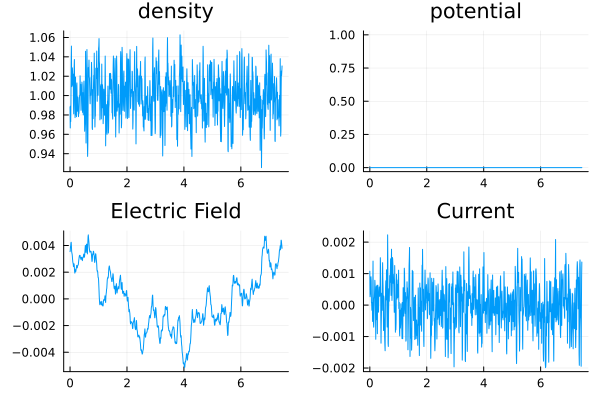

In [10]:
if !remote_server 
    plt = plot(layout=(2,2))
    plot!(subplot=1,x,n, title = "density", legend = :false)
    plot!(subplot=2,x,ϕ, title = "potential", legend = :false)
    plot!(subplot=3,x,E_i, title = "Electric Field", legend = :false)
    
    plot!(subplot=4,x,S, title = "Current", legend = :false)
end

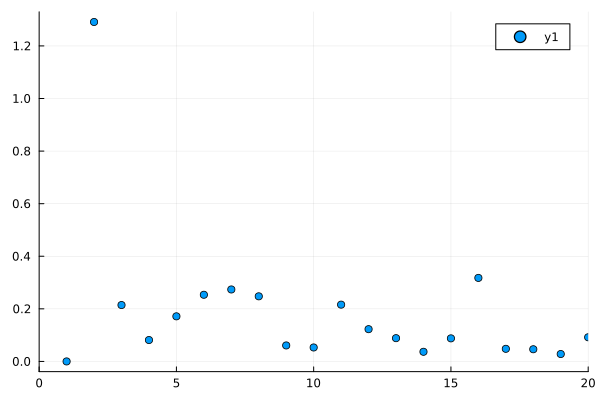

In [11]:
E_Fourier = rfft(u[2N+1:end])
Plots.scatter(abs.((E_Fourier)),xlim=(0,20))

In [12]:
rfft(u[2N+1:end])[nm+1]

0.060145630933730654 + 0.31190415932386045im

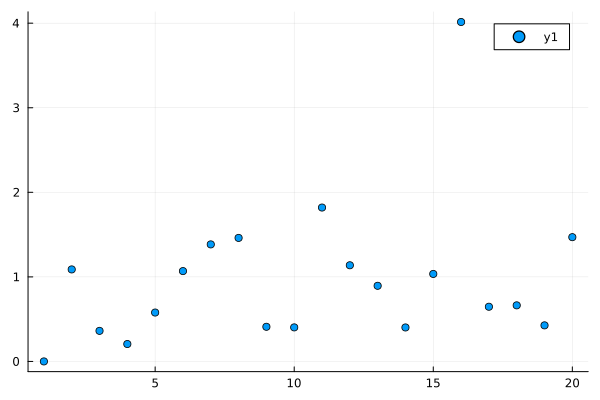

In [13]:
n_Fourier = rfft(n.-1)
freqs_space = fftshift(fftfreq(J,1/dx))
#Plots.scatter(freqs_space,abs.(fftshift(n_Fourier)))
Plots.scatter(abs.(n_Fourier)[1:20])

Check the histograms for the initial positions and velocities.

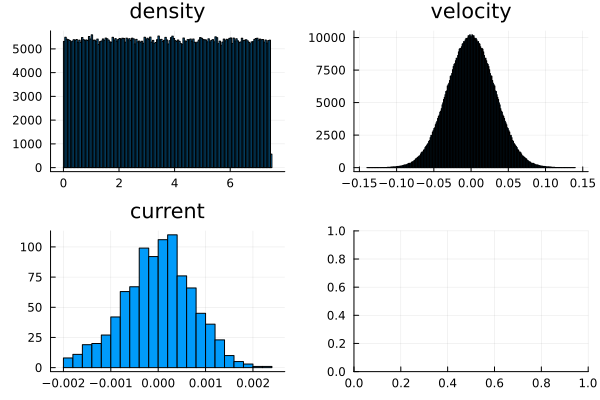

In [14]:
if !remote_server
    plot(layout=(2,2))
    histogram!(subplot=1,u[1:N], title = "density", legend = :false, bins = 300)
    histogram!(subplot=2,u[N+1:2*N], title = "velocity", legend = :false)

    histogram!(subplot=3,S, title = "current", legend = :false)
end

In [15]:
T = get_temperature_rel(u,N)

0.000991326194033053

In [16]:
if phase_space_show
Plots.scatter(u[1:N],u[N+1:2N]
, thickness_scaling = 0.3
, markersize = 0.3
, title = "phase-space", legend =:false)
png(run_name * "initial-phase-space")
end

"norel_norm_damped_rel_t40_L7.455_N85_n15_J930_M4001_o5_Th3_alp2initial-phase-space.png"

## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [17]:
if nthreads() > 1
TS = zeros(J, nthreads())
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current_rel_threads!, Interpolate_2, TS) ;
else
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current_rel!, Interpolate_2) ;
end


(800000, 930, 7.455, 0.008016129032258065, 5, [0.9884275375570769, 0.966579991440499, 0.9891429953633532, 0.9731719963164603, 0.9954679184431996, 1.0350073118430434, 1.0510905538961721, 1.014342474969566, 1.0092109534294156, 1.0198616641402736  …  0.9778174791312799, 1.0381026728172016, 0.9880517683868789, 0.9581069042823589, 0.9632114851623839, 1.0052700651521318, 1.0253446345717026, 1.0206005600776527, 1.025123050189195, 1.0305719752492326], [0.0010764654311708221, 0.0002648190172262951, 0.0003415791565421843, 0.0004483340533011573, 0.0008682103446300231, 0.0008997662775289571, 0.0007700200141751989, 8.190258719743235e-5, 5.244146901020364e-5, -0.00016568157424931535  …  0.0012930911662295426, 0.0014339937899921793, 0.0011964835146438073, -0.00036605771415896795, -0.00044215332145554765, -0.000804469922211761, -0.001944540019856682, -0.00025874778055112534, 0.0008543413773250798, 0.001368044348889882], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [18]:
t = 0.0
j = 1

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => pars_f)

if full_outputs
    run_name = run_name * "_full"
elseif average_outputs
    run_name = run_name * "_ave"
end

file_name = "Results/"* run_name * ".jld2"
#rm(file_name)




save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

if full_outputs
    field_name = "u"
    tiempo = @sprintf("%05d", j)
    jldopen(file_name, "a+") do file
        file[field_name * "/u_$(tiempo)"] = u;
    end
end

if average_outputs
    load_averages(file_name, j, par_grid, pars_f)
end


0.31765028179420945

In [19]:

for k in 2:M
  RK4_Step!(RHSC_rel,u,t,dt,p_RHSC)
  global u = [make_periodic!(u[1:N],L); u[N+1:end]]
  #filter_constant!(u[2N+1:end])
  global t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    local j = (k-1)÷(M÷(M_g-1))+1
    Energy_Ks, Energy_Es = get_energy_rel(u,(L, N, J))

    if average_outputs
      load_averages(file_name, j, par_grid, pars_f)
    end

    if full_outputs
        local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
      end
    end

    println("j = $j , t = $t, k = $k, nthreads = $(nthreads()), Energy = $(Energy_Ks + Energy_Es)")

    if animation
      par[j,:] = u[1:2N]
    end
  end
end

j = 2 , t = 0.09999999999999999, k = 11, nthreads = 2, Energy = 0.00372246888461022


j = 3 , t = 0.20000000000000004, k = 21, nthreads = 2, Energy = 0.0037224679953295867


j = 4 , t = 0.3000000000000001, k = 31, nthreads = 2, Energy = 0.003722467181309054


j = 5 , t = 0.4000000000000002, k = 41, nthreads = 2, Energy = 0.0037224668215685894


j = 6 , t = 0.5000000000000002, k = 51, nthreads = 2, Energy = 0.003722466469603699


j = 7 , t = 0.6000000000000003, k = 61, nthreads = 2, Energy = 0.003722465506867518


j = 8 , t = 0.7000000000000004, k = 71, nthreads = 2, Energy = 0.003722464223418494


j = 9 , t = 0.8000000000000005, k = 81, nthreads = 2, Energy = 0.003722463335478389


j = 10 , t = 0.9000000000000006, k = 91, nthreads = 2, Energy = 0.0037224632704832045


j = 11 , t = 1.0000000000000007, k = 101, nthreads = 2, Energy = 0.0037224630438818236


j = 12 , t = 1.1000000000000008, k = 111, nthreads = 2, Energy = 0.0037224624870464667


j = 13 , t = 1.2000000000000008, k = 121, nthreads = 2, Energy = 0.003722462270183773


j = 14 , t = 1.300000000000001, k = 131, nthreads = 2, Energy = 0.0037224622306869667


j = 15 , t = 1.400000000000001, k = 141, nthreads = 2, Energy = 0.003722461774075532


j = 16 , t = 1.500000000000001, k = 151, nthreads = 2, Energy = 0.003722461706033


j = 17 , t = 1.6000000000000012, k = 161, nthreads = 2, Energy = 0.003722461657540888


j = 18 , t = 1.7000000000000013, k = 171, nthreads = 2, Energy = 0.0037224617019768307


j = 19 , t = 1.8000000000000014, k = 181, nthreads = 2, Energy = 0.003722462454061614


j = 20 , t = 1.9000000000000015, k = 191, nthreads = 2, Energy = 0.003722463265457006


j = 21 , t = 2.0000000000000013, k = 201, nthreads = 2, Energy = 0.0037224628761866685


j = 22 , t = 2.099999999999999, k = 211, nthreads = 2, Energy = 0.003722461996282931


j = 23 , t = 2.199999999999997, k = 221, nthreads = 2, Energy = 0.003722461830021257


j = 24 , t = 2.299999999999995, k = 231, nthreads = 2, Energy = 0.0037224620084585075


j = 25 , t = 2.399999999999993, k = 241, nthreads = 2, Energy = 0.003722462087312177


j = 26 , t = 2.4999999999999907, k = 251, nthreads = 2, Energy = 0.003722462263741466


j = 27 , t = 2.5999999999999885, k = 261, nthreads = 2, Energy = 0.0037224628120707


j = 28 , t = 2.6999999999999864, k = 271, nthreads = 2, Energy = 0.0037224631128018764


j = 29 , t = 2.7999999999999843, k = 281, nthreads = 2, Energy = 0.003722462715447757


j = 30 , t = 2.899999999999982, k = 291, nthreads = 2, Energy = 0.003722462359070321


j = 31 , t = 2.99999999999998, k = 301, nthreads = 2, Energy = 0.0037224627045414392


j = 32 , t = 3.099999999999978, k = 311, nthreads = 2, Energy = 0.0037224633636726


j = 33 , t = 3.1999999999999758, k = 321, nthreads = 2, Energy = 0.003722463478247784


j = 34 , t = 3.2999999999999736, k = 331, nthreads = 2, Energy = 0.003722462716965719


j = 35 , t = 3.3999999999999715, k = 341, nthreads = 2, Energy = 0.0037224616528524195


j = 36 , t = 3.4999999999999694, k = 351, nthreads = 2, Energy = 0.003722461719348856


j = 37 , t = 3.5999999999999672, k = 361, nthreads = 2, Energy = 0.003722462212871219


j = 38 , t = 3.699999999999965, k = 371, nthreads = 2, Energy = 0.003722462241375155


j = 39 , t = 3.799999999999963, k = 381, nthreads = 2, Energy = 0.0037224623119582784


j = 40 , t = 3.899999999999961, k = 391, nthreads = 2, Energy = 0.003722463188677306


j = 41 , t = 3.9999999999999587, k = 401, nthreads = 2, Energy = 0.003722463596746563


j = 42 , t = 4.099999999999957, k = 411, nthreads = 2, Energy = 0.0037224628506897007


j = 43 , t = 4.199999999999955, k = 421, nthreads = 2, Energy = 0.003722462425966532


j = 44 , t = 4.299999999999953, k = 431, nthreads = 2, Energy = 0.003722462156142946


j = 45 , t = 4.399999999999951, k = 441, nthreads = 2, Energy = 0.0037224615919157216


j = 46 , t = 4.4999999999999485, k = 451, nthreads = 2, Energy = 0.0037224609930706213


j = 47 , t = 4.599999999999946, k = 461, nthreads = 2, Energy = 0.0037224611880108203


j = 48 , t = 4.699999999999944, k = 471, nthreads = 2, Energy = 0.0037224615617445136


j = 49 , t = 4.799999999999942, k = 481, nthreads = 2, Energy = 0.003722461827016914


j = 50 , t = 4.89999999999994, k = 491, nthreads = 2, Energy = 0.0037224619496218797


j = 51 , t = 4.999999999999938, k = 501, nthreads = 2, Energy = 0.003722461920516827


j = 52 , t = 5.099999999999936, k = 511, nthreads = 2, Energy = 0.0037224621236098226


j = 53 , t = 5.199999999999934, k = 521, nthreads = 2, Energy = 0.0037224624302949257


j = 54 , t = 5.299999999999931, k = 531, nthreads = 2, Energy = 0.0037224624221985692


j = 55 , t = 5.399999999999929, k = 541, nthreads = 2, Energy = 0.0037224621693780625


j = 56 , t = 5.499999999999927, k = 551, nthreads = 2, Energy = 0.003722462251935119


j = 57 , t = 5.599999999999925, k = 561, nthreads = 2, Energy = 0.0037224621824331365


j = 58 , t = 5.699999999999923, k = 571, nthreads = 2, Energy = 0.0037224616953550832


j = 59 , t = 5.799999999999921, k = 581, nthreads = 2, Energy = 0.003722462558863982


j = 60 , t = 5.899999999999919, k = 591, nthreads = 2, Energy = 0.0037224633280715687


j = 61 , t = 5.9999999999999165, k = 601, nthreads = 2, Energy = 0.003722463672028272


j = 62 , t = 6.099999999999914, k = 611, nthreads = 2, Energy = 0.003722463517791876


j = 63 , t = 6.199999999999912, k = 621, nthreads = 2, Energy = 0.0037224627920684145


j = 64 , t = 6.29999999999991, k = 631, nthreads = 2, Energy = 0.003722461867023075


j = 65 , t = 6.399999999999908, k = 641, nthreads = 2, Energy = 0.0037224618263287782


j = 66 , t = 6.499999999999906, k = 651, nthreads = 2, Energy = 0.003722461685619553


j = 67 , t = 6.599999999999904, k = 661, nthreads = 2, Energy = 0.003722461659150543


j = 68 , t = 6.699999999999902, k = 671, nthreads = 2, Energy = 0.003722461822683715


j = 69 , t = 6.7999999999998995, k = 681, nthreads = 2, Energy = 0.003722461907251941


j = 70 , t = 6.899999999999897, k = 691, nthreads = 2, Energy = 0.0037224612331191293


j = 71 , t = 6.999999999999895, k = 701, nthreads = 2, Energy = 0.0037224608549168477


j = 72 , t = 7.099999999999893, k = 711, nthreads = 2, Energy = 0.0037224612327128614


j = 73 , t = 7.199999999999891, k = 721, nthreads = 2, Energy = 0.0037224616054560484


j = 74 , t = 7.299999999999889, k = 731, nthreads = 2, Energy = 0.0037224618335894243


j = 75 , t = 7.399999999999887, k = 741, nthreads = 2, Energy = 0.0037224618230564783


j = 76 , t = 7.4999999999998845, k = 751, nthreads = 2, Energy = 0.003722462043036182


j = 77 , t = 7.599999999999882, k = 761, nthreads = 2, Energy = 0.003722461818019408


j = 78 , t = 7.69999999999988, k = 771, nthreads = 2, Energy = 0.003722461759280869


j = 79 , t = 7.799999999999878, k = 781, nthreads = 2, Energy = 0.003722462113181134


j = 80 , t = 7.899999999999876, k = 791, nthreads = 2, Energy = 0.0037224623666631644


j = 81 , t = 7.999999999999874, k = 801, nthreads = 2, Energy = 0.0037224626643998513


j = 82 , t = 8.099999999999872, k = 811, nthreads = 2, Energy = 0.0037224626472506764


j = 83 , t = 8.19999999999987, k = 821, nthreads = 2, Energy = 0.003722462613479334


j = 84 , t = 8.299999999999867, k = 831, nthreads = 2, Energy = 0.0037224629180441747


j = 85 , t = 8.399999999999865, k = 841, nthreads = 2, Energy = 0.0037224630176961016


j = 86 , t = 8.499999999999863, k = 851, nthreads = 2, Energy = 0.00372246334164787


j = 87 , t = 8.599999999999861, k = 861, nthreads = 2, Energy = 0.003722463033212346


j = 88 , t = 8.699999999999859, k = 871, nthreads = 2, Energy = 0.0037224626807544643


j = 89 , t = 8.799999999999857, k = 881, nthreads = 2, Energy = 0.00372246251508824


j = 90 , t = 8.899999999999855, k = 891, nthreads = 2, Energy = 0.0037224621515998383


j = 91 , t = 8.999999999999853, k = 901, nthreads = 2, Energy = 0.0037224620579709234


j = 92 , t = 9.09999999999985, k = 911, nthreads = 2, Energy = 0.0037224614893398636


j = 93 , t = 9.199999999999848, k = 921, nthreads = 2, Energy = 0.0037224606877112733


j = 94 , t = 9.299999999999846, k = 931, nthreads = 2, Energy = 0.0037224600157767375


j = 95 , t = 9.399999999999844, k = 941, nthreads = 2, Energy = 0.0037224601231472315


j = 96 , t = 9.499999999999842, k = 951, nthreads = 2, Energy = 0.003722460195156395


j = 97 , t = 9.59999999999984, k = 961, nthreads = 2, Energy = 0.0037224606727288825


j = 98 , t = 9.699999999999838, k = 971, nthreads = 2, Energy = 0.0037224614935625635


j = 99 , t = 9.799999999999836, k = 981, nthreads = 2, Energy = 0.003722461859778809


j = 100 , t = 9.899999999999833, k = 991, nthreads = 2, Energy = 0.0037224621909343744


j = 101 , t = 9.999999999999831, k = 1001, nthreads = 2, Energy = 0.0037224621246110057


j = 102 , t = 10.09999999999983, k = 1011, nthreads = 2, Energy = 0.003722462113556697


j = 103 , t = 10.199999999999827, k = 1021, nthreads = 2, Energy = 0.003722462202519818


j = 104 , t = 10.299999999999825, k = 1031, nthreads = 2, Energy = 0.003722461888202896


j = 105 , t = 10.399999999999823, k = 1041, nthreads = 2, Energy = 0.0037224613891739407


j = 106 , t = 10.49999999999982, k = 1051, nthreads = 2, Energy = 0.003722461024681176


j = 107 , t = 10.599999999999818, k = 1061, nthreads = 2, Energy = 0.003722461276246494


j = 108 , t = 10.699999999999816, k = 1071, nthreads = 2, Energy = 0.0037224621045013504


j = 109 , t = 10.799999999999814, k = 1081, nthreads = 2, Energy = 0.0037224625614140413


j = 110 , t = 10.899999999999812, k = 1091, nthreads = 2, Energy = 0.0037224625996091537


j = 111 , t = 10.99999999999981, k = 1101, nthreads = 2, Energy = 0.0037224625133922256


j = 112 , t = 11.099999999999808, k = 1111, nthreads = 2, Energy = 0.003722462593240741


j = 113 , t = 11.199999999999806, k = 1121, nthreads = 2, Energy = 0.003722462796862682


j = 114 , t = 11.299999999999804, k = 1131, nthreads = 2, Energy = 0.003722462909775337


j = 115 , t = 11.399999999999801, k = 1141, nthreads = 2, Energy = 0.0037224625443516234


j = 116 , t = 11.4999999999998, k = 1151, nthreads = 2, Energy = 0.003722462392228319


j = 117 , t = 11.599999999999797, k = 1161, nthreads = 2, Energy = 0.00372246253259334


j = 118 , t = 11.699999999999795, k = 1171, nthreads = 2, Energy = 0.003722462985784446


j = 119 , t = 11.799999999999793, k = 1181, nthreads = 2, Energy = 0.0037224641543509196


j = 120 , t = 11.89999999999979, k = 1191, nthreads = 2, Energy = 0.0037224651179969845


j = 121 , t = 11.999999999999789, k = 1201, nthreads = 2, Energy = 0.0037224648721339427


j = 122 , t = 12.099999999999786, k = 1211, nthreads = 2, Energy = 0.0037224641442260725


j = 123 , t = 12.199999999999784, k = 1221, nthreads = 2, Energy = 0.003722463967873769


j = 124 , t = 12.299999999999782, k = 1231, nthreads = 2, Energy = 0.003722463973279605


j = 125 , t = 12.39999999999978, k = 1241, nthreads = 2, Energy = 0.0037224630992574175


j = 126 , t = 12.499999999999778, k = 1251, nthreads = 2, Energy = 0.0037224624325072632


j = 127 , t = 12.599999999999776, k = 1261, nthreads = 2, Energy = 0.0037224625567585405


j = 128 , t = 12.699999999999774, k = 1271, nthreads = 2, Energy = 0.003722462695751928


j = 129 , t = 12.799999999999772, k = 1281, nthreads = 2, Energy = 0.0037224625321189554


j = 130 , t = 12.89999999999977, k = 1291, nthreads = 2, Energy = 0.003722462564272258


j = 131 , t = 12.999999999999767, k = 1301, nthreads = 2, Energy = 0.003722462481899148


j = 132 , t = 13.099999999999765, k = 1311, nthreads = 2, Energy = 0.00372246213798269


j = 133 , t = 13.199999999999763, k = 1321, nthreads = 2, Energy = 0.003722462277792805


j = 134 , t = 13.299999999999761, k = 1331, nthreads = 2, Energy = 0.0037224626408365233


j = 135 , t = 13.399999999999759, k = 1341, nthreads = 2, Energy = 0.003722462763735524


j = 136 , t = 13.499999999999757, k = 1351, nthreads = 2, Energy = 0.0037224628864179


j = 137 , t = 13.599999999999755, k = 1361, nthreads = 2, Energy = 0.0037224627557930897


j = 138 , t = 13.699999999999752, k = 1371, nthreads = 2, Energy = 0.0037224625261252195


j = 139 , t = 13.79999999999975, k = 1381, nthreads = 2, Energy = 0.0037224622018097843


j = 140 , t = 13.899999999999748, k = 1391, nthreads = 2, Energy = 0.003722461356553211


j = 141 , t = 13.999999999999746, k = 1401, nthreads = 2, Energy = 0.003722460660400731


j = 142 , t = 14.099999999999744, k = 1411, nthreads = 2, Energy = 0.0037224606415518697


j = 143 , t = 14.199999999999742, k = 1421, nthreads = 2, Energy = 0.0037224618421571056


j = 144 , t = 14.29999999999974, k = 1431, nthreads = 2, Energy = 0.003722463335279437


j = 145 , t = 14.399999999999737, k = 1441, nthreads = 2, Energy = 0.0037224648377834403


j = 146 , t = 14.499999999999735, k = 1451, nthreads = 2, Energy = 0.003722466012236426


j = 147 , t = 14.599999999999733, k = 1461, nthreads = 2, Energy = 0.0037224661526192035


j = 148 , t = 14.699999999999731, k = 1471, nthreads = 2, Energy = 0.003722465391519241


j = 149 , t = 14.799999999999729, k = 1481, nthreads = 2, Energy = 0.0037224647276199825


j = 150 , t = 14.899999999999727, k = 1491, nthreads = 2, Energy = 0.0037224644965351103


j = 151 , t = 14.999999999999725, k = 1501, nthreads = 2, Energy = 0.003722464071020827


j = 152 , t = 15.099999999999723, k = 1511, nthreads = 2, Energy = 0.0037224630057577004


j = 153 , t = 15.19999999999972, k = 1521, nthreads = 2, Energy = 0.0037224623071749315


j = 154 , t = 15.299999999999718, k = 1531, nthreads = 2, Energy = 0.0037224626074122335


j = 155 , t = 15.399999999999716, k = 1541, nthreads = 2, Energy = 0.003722462879086858


j = 156 , t = 15.499999999999714, k = 1551, nthreads = 2, Energy = 0.0037224630112094913


j = 157 , t = 15.599999999999712, k = 1561, nthreads = 2, Energy = 0.003722462811314216


j = 158 , t = 15.69999999999971, k = 1571, nthreads = 2, Energy = 0.003722462112329644


j = 159 , t = 15.799999999999708, k = 1581, nthreads = 2, Energy = 0.003722461920418421


j = 160 , t = 15.899999999999705, k = 1591, nthreads = 2, Energy = 0.003722461658162747


j = 161 , t = 15.999999999999703, k = 1601, nthreads = 2, Energy = 0.0037224612617179536


j = 162 , t = 16.099999999999717, k = 1611, nthreads = 2, Energy = 0.003722461243665886


j = 163 , t = 16.199999999999733, k = 1621, nthreads = 2, Energy = 0.0037224610920867825


j = 164 , t = 16.29999999999975, k = 1631, nthreads = 2, Energy = 0.0037224612079190403


j = 165 , t = 16.399999999999764, k = 1641, nthreads = 2, Energy = 0.0037224612257077826


j = 166 , t = 16.49999999999978, k = 1651, nthreads = 2, Energy = 0.0037224612436354085


j = 167 , t = 16.599999999999795, k = 1661, nthreads = 2, Energy = 0.00372246110914617


j = 168 , t = 16.69999999999981, k = 1671, nthreads = 2, Energy = 0.0037224610285052453


j = 169 , t = 16.799999999999827, k = 1681, nthreads = 2, Energy = 0.0037224612975460362


j = 170 , t = 16.899999999999842, k = 1691, nthreads = 2, Energy = 0.0037224616551386315


j = 171 , t = 16.999999999999858, k = 1701, nthreads = 2, Energy = 0.0037224623573318565


j = 172 , t = 17.099999999999874, k = 1711, nthreads = 2, Energy = 0.003722462528555718


j = 173 , t = 17.19999999999989, k = 1721, nthreads = 2, Energy = 0.0037224625672240765


j = 174 , t = 17.299999999999905, k = 1731, nthreads = 2, Energy = 0.0037224623038319203


j = 175 , t = 17.39999999999992, k = 1741, nthreads = 2, Energy = 0.0037224617659890815


j = 176 , t = 17.499999999999936, k = 1751, nthreads = 2, Energy = 0.003722460731481591


j = 177 , t = 17.59999999999995, k = 1761, nthreads = 2, Energy = 0.0037224600363525567


j = 178 , t = 17.699999999999967, k = 1771, nthreads = 2, Energy = 0.0037224601658618637


j = 179 , t = 17.799999999999983, k = 1781, nthreads = 2, Energy = 0.0037224608155937734


j = 180 , t = 17.9, k = 1791, nthreads = 2, Energy = 0.0037224614962045243


j = 181 , t = 18.000000000000014, k = 1801, nthreads = 2, Energy = 0.0037224620592039665


j = 182 , t = 18.10000000000003, k = 1811, nthreads = 2, Energy = 0.0037224621846726276


j = 183 , t = 18.200000000000045, k = 1821, nthreads = 2, Energy = 0.003722462370545458


j = 184 , t = 18.30000000000006, k = 1831, nthreads = 2, Energy = 0.0037224624248377945


j = 185 , t = 18.400000000000077, k = 1841, nthreads = 2, Energy = 0.003722462079214525


j = 186 , t = 18.500000000000092, k = 1851, nthreads = 2, Energy = 0.00372246143108162


j = 187 , t = 18.600000000000108, k = 1861, nthreads = 2, Energy = 0.003722461189051361


j = 188 , t = 18.700000000000124, k = 1871, nthreads = 2, Energy = 0.0037224611815468277


j = 189 , t = 18.80000000000014, k = 1881, nthreads = 2, Energy = 0.003722460864905161


j = 190 , t = 18.900000000000155, k = 1891, nthreads = 2, Energy = 0.003722460497150298


j = 191 , t = 19.00000000000017, k = 1901, nthreads = 2, Energy = 0.003722460085492895


j = 192 , t = 19.100000000000186, k = 1911, nthreads = 2, Energy = 0.0037224602589115696


j = 193 , t = 19.200000000000202, k = 1921, nthreads = 2, Energy = 0.00372246056902901


j = 194 , t = 19.300000000000217, k = 1931, nthreads = 2, Energy = 0.003722460783600973


j = 195 , t = 19.400000000000233, k = 1941, nthreads = 2, Energy = 0.003722460885920883


j = 196 , t = 19.50000000000025, k = 1951, nthreads = 2, Energy = 0.0037224612833678204


j = 197 , t = 19.600000000000264, k = 1961, nthreads = 2, Energy = 0.003722461737905908


j = 198 , t = 19.70000000000028, k = 1971, nthreads = 2, Energy = 0.003722462085585506


j = 199 , t = 19.800000000000296, k = 1981, nthreads = 2, Energy = 0.0037224625250064217


j = 200 , t = 19.90000000000031, k = 1991, nthreads = 2, Energy = 0.00372246279943741


j = 201 , t = 20.000000000000327, k = 2001, nthreads = 2, Energy = 0.003722463159710319


j = 202 , t = 20.100000000000342, k = 2011, nthreads = 2, Energy = 0.003722463009043614


j = 203 , t = 20.200000000000358, k = 2021, nthreads = 2, Energy = 0.0037224627337078104


j = 204 , t = 20.300000000000374, k = 2031, nthreads = 2, Energy = 0.0037224621075180684


j = 205 , t = 20.40000000000039, k = 2041, nthreads = 2, Energy = 0.003722461368182053


j = 206 , t = 20.500000000000405, k = 2051, nthreads = 2, Energy = 0.0037224612912969894


j = 207 , t = 20.60000000000042, k = 2061, nthreads = 2, Energy = 0.0037224613823376067


j = 208 , t = 20.700000000000436, k = 2071, nthreads = 2, Energy = 0.0037224612616999233


j = 209 , t = 20.800000000000452, k = 2081, nthreads = 2, Energy = 0.003722461260221161


j = 210 , t = 20.900000000000468, k = 2091, nthreads = 2, Energy = 0.003722461507377245


j = 211 , t = 21.000000000000483, k = 2101, nthreads = 2, Energy = 0.003722461645775701


j = 212 , t = 21.1000000000005, k = 2111, nthreads = 2, Energy = 0.003722461547366436


j = 213 , t = 21.200000000000514, k = 2121, nthreads = 2, Energy = 0.003722461721544858


j = 214 , t = 21.30000000000053, k = 2131, nthreads = 2, Energy = 0.0037224621161152586


j = 215 , t = 21.400000000000546, k = 2141, nthreads = 2, Energy = 0.0037224620375366814


j = 216 , t = 21.50000000000056, k = 2151, nthreads = 2, Energy = 0.003722461949455546


j = 217 , t = 21.600000000000577, k = 2161, nthreads = 2, Energy = 0.003722461843322098


j = 218 , t = 21.700000000000593, k = 2171, nthreads = 2, Energy = 0.003722461596905944


j = 219 , t = 21.80000000000061, k = 2181, nthreads = 2, Energy = 0.003722461403203234


j = 220 , t = 21.900000000000624, k = 2191, nthreads = 2, Energy = 0.0037224615117902233


j = 221 , t = 22.00000000000064, k = 2201, nthreads = 2, Energy = 0.0037224614083313573


j = 222 , t = 22.100000000000655, k = 2211, nthreads = 2, Energy = 0.0037224614370326087


j = 223 , t = 22.20000000000067, k = 2221, nthreads = 2, Energy = 0.0037224611717929196


j = 224 , t = 22.300000000000686, k = 2231, nthreads = 2, Energy = 0.003722460942243288


j = 225 , t = 22.400000000000702, k = 2241, nthreads = 2, Energy = 0.003722461119946119


j = 226 , t = 22.500000000000718, k = 2251, nthreads = 2, Energy = 0.0037224613491850986


j = 227 , t = 22.600000000000733, k = 2261, nthreads = 2, Energy = 0.003722461147310892


j = 228 , t = 22.70000000000075, k = 2271, nthreads = 2, Energy = 0.003722461135547825


j = 229 , t = 22.800000000000765, k = 2281, nthreads = 2, Energy = 0.0037224617064971115


j = 230 , t = 22.90000000000078, k = 2291, nthreads = 2, Energy = 0.0037224618447118172


j = 231 , t = 23.000000000000796, k = 2301, nthreads = 2, Energy = 0.003722461825639143


j = 232 , t = 23.10000000000081, k = 2311, nthreads = 2, Energy = 0.003722461731694798


j = 233 , t = 23.200000000000827, k = 2321, nthreads = 2, Energy = 0.0037224623207276616


j = 234 , t = 23.300000000000843, k = 2331, nthreads = 2, Energy = 0.003722463237291026


j = 235 , t = 23.40000000000086, k = 2341, nthreads = 2, Energy = 0.0037224636882525848


j = 236 , t = 23.500000000000874, k = 2351, nthreads = 2, Energy = 0.0037224634050525133


j = 237 , t = 23.60000000000089, k = 2361, nthreads = 2, Energy = 0.003722463550908011


j = 238 , t = 23.700000000000905, k = 2371, nthreads = 2, Energy = 0.0037224636463948236


j = 239 , t = 23.80000000000092, k = 2381, nthreads = 2, Energy = 0.003722463360699633


j = 240 , t = 23.900000000000936, k = 2391, nthreads = 2, Energy = 0.003722463213100411


j = 241 , t = 24.000000000000952, k = 2401, nthreads = 2, Energy = 0.003722462775142118


j = 242 , t = 24.100000000000968, k = 2411, nthreads = 2, Energy = 0.003722462235338625


j = 243 , t = 24.200000000000983, k = 2421, nthreads = 2, Energy = 0.003722461782263455


j = 244 , t = 24.300000000001, k = 2431, nthreads = 2, Energy = 0.003722461065238182


j = 245 , t = 24.400000000001015, k = 2441, nthreads = 2, Energy = 0.0037224606162710285


j = 246 , t = 24.50000000000103, k = 2451, nthreads = 2, Energy = 0.0037224608104188526


j = 247 , t = 24.600000000001046, k = 2461, nthreads = 2, Energy = 0.003722461421672931


j = 248 , t = 24.70000000000106, k = 2471, nthreads = 2, Energy = 0.003722461570470611


j = 249 , t = 24.800000000001077, k = 2481, nthreads = 2, Energy = 0.003722461360945976


j = 250 , t = 24.900000000001093, k = 2491, nthreads = 2, Energy = 0.003722461189632389


j = 251 , t = 25.00000000000111, k = 2501, nthreads = 2, Energy = 0.003722461007834652


j = 252 , t = 25.100000000001124, k = 2511, nthreads = 2, Energy = 0.003722460657010082


j = 253 , t = 25.20000000000114, k = 2521, nthreads = 2, Energy = 0.003722460766970451


j = 254 , t = 25.300000000001155, k = 2531, nthreads = 2, Energy = 0.003722461242726267


j = 255 , t = 25.40000000000117, k = 2541, nthreads = 2, Energy = 0.003722462111828629


j = 256 , t = 25.500000000001187, k = 2551, nthreads = 2, Energy = 0.00372246290084967


j = 257 , t = 25.600000000001202, k = 2561, nthreads = 2, Energy = 0.003722462563873576


j = 258 , t = 25.700000000001218, k = 2571, nthreads = 2, Energy = 0.0037224623115376374


j = 259 , t = 25.800000000001234, k = 2581, nthreads = 2, Energy = 0.003722461956410422


j = 260 , t = 25.90000000000125, k = 2591, nthreads = 2, Energy = 0.0037224617286753412


j = 261 , t = 26.000000000001265, k = 2601, nthreads = 2, Energy = 0.003722461461030793


j = 262 , t = 26.10000000000128, k = 2611, nthreads = 2, Energy = 0.003722461032532477


j = 263 , t = 26.200000000001296, k = 2621, nthreads = 2, Energy = 0.0037224610695272835


j = 264 , t = 26.30000000000131, k = 2631, nthreads = 2, Energy = 0.003722461394013769


j = 265 , t = 26.400000000001327, k = 2641, nthreads = 2, Energy = 0.003722461193820504


j = 266 , t = 26.500000000001343, k = 2651, nthreads = 2, Energy = 0.0037224610133551527


j = 267 , t = 26.60000000000136, k = 2661, nthreads = 2, Energy = 0.0037224613094820956


j = 268 , t = 26.700000000001374, k = 2671, nthreads = 2, Energy = 0.0037224614070051234


j = 269 , t = 26.80000000000139, k = 2681, nthreads = 2, Energy = 0.0037224612722437174


j = 270 , t = 26.900000000001405, k = 2691, nthreads = 2, Energy = 0.003722460952243429


j = 271 , t = 27.00000000000142, k = 2701, nthreads = 2, Energy = 0.0037224608013283647


j = 272 , t = 27.100000000001437, k = 2711, nthreads = 2, Energy = 0.003722461101163629


j = 273 , t = 27.200000000001452, k = 2721, nthreads = 2, Energy = 0.003722461963433302


j = 274 , t = 27.300000000001468, k = 2731, nthreads = 2, Energy = 0.0037224625251827833


j = 275 , t = 27.400000000001484, k = 2741, nthreads = 2, Energy = 0.0037224625120697605


j = 276 , t = 27.5000000000015, k = 2751, nthreads = 2, Energy = 0.003722462836845524


j = 277 , t = 27.600000000001515, k = 2761, nthreads = 2, Energy = 0.0037224631333631466


j = 278 , t = 27.70000000000153, k = 2771, nthreads = 2, Energy = 0.003722462532399946


j = 279 , t = 27.800000000001546, k = 2781, nthreads = 2, Energy = 0.0037224620108020114


j = 280 , t = 27.90000000000156, k = 2791, nthreads = 2, Energy = 0.003722461899645136


j = 281 , t = 28.000000000001577, k = 2801, nthreads = 2, Energy = 0.0037224618256266116


j = 282 , t = 28.100000000001593, k = 2811, nthreads = 2, Energy = 0.0037224620510366265


j = 283 , t = 28.20000000000161, k = 2821, nthreads = 2, Energy = 0.0037224626684253105


j = 284 , t = 28.300000000001624, k = 2831, nthreads = 2, Energy = 0.0037224627681864465


j = 285 , t = 28.40000000000164, k = 2841, nthreads = 2, Energy = 0.00372246212156328


j = 286 , t = 28.500000000001656, k = 2851, nthreads = 2, Energy = 0.0037224618111481793


j = 287 , t = 28.60000000000167, k = 2861, nthreads = 2, Energy = 0.0037224620515163395


j = 288 , t = 28.700000000001687, k = 2871, nthreads = 2, Energy = 0.0037224619984796946


j = 289 , t = 28.800000000001702, k = 2881, nthreads = 2, Energy = 0.0037224621270395154


j = 290 , t = 28.900000000001718, k = 2891, nthreads = 2, Energy = 0.0037224621325430765


j = 291 , t = 29.000000000001734, k = 2901, nthreads = 2, Energy = 0.0037224618533538032


j = 292 , t = 29.10000000000175, k = 2911, nthreads = 2, Energy = 0.0037224615811973422


j = 293 , t = 29.200000000001765, k = 2921, nthreads = 2, Energy = 0.00372246173900027


j = 294 , t = 29.30000000000178, k = 2931, nthreads = 2, Energy = 0.003722461813538607


j = 295 , t = 29.400000000001796, k = 2941, nthreads = 2, Energy = 0.0037224615054246525


j = 296 , t = 29.500000000001812, k = 2951, nthreads = 2, Energy = 0.0037224610880927204


j = 297 , t = 29.600000000001828, k = 2961, nthreads = 2, Energy = 0.0037224610022510464


j = 298 , t = 29.700000000001843, k = 2971, nthreads = 2, Energy = 0.0037224615734495863


j = 299 , t = 29.80000000000186, k = 2981, nthreads = 2, Energy = 0.003722462191725372


j = 300 , t = 29.900000000001874, k = 2991, nthreads = 2, Energy = 0.0037224625343843507


j = 301 , t = 30.00000000000189, k = 3001, nthreads = 2, Energy = 0.0037224628379502597


j = 302 , t = 30.100000000001906, k = 3011, nthreads = 2, Energy = 0.0037224632328815557


j = 303 , t = 30.20000000000192, k = 3021, nthreads = 2, Energy = 0.0037224637839180182


j = 304 , t = 30.300000000001937, k = 3031, nthreads = 2, Energy = 0.0037224642190913917


j = 305 , t = 30.400000000001953, k = 3041, nthreads = 2, Energy = 0.0037224642602415965


j = 306 , t = 30.500000000001968, k = 3051, nthreads = 2, Energy = 0.003722464336999495


j = 307 , t = 30.600000000001984, k = 3061, nthreads = 2, Energy = 0.0037224641679609984


j = 308 , t = 30.700000000002, k = 3071, nthreads = 2, Energy = 0.0037224643385381185


j = 309 , t = 30.800000000002015, k = 3081, nthreads = 2, Energy = 0.0037224648363851824


j = 310 , t = 30.90000000000203, k = 3091, nthreads = 2, Energy = 0.0037224643478275237


j = 311 , t = 31.000000000002046, k = 3101, nthreads = 2, Energy = 0.003722464373442786


j = 312 , t = 31.100000000002062, k = 3111, nthreads = 2, Energy = 0.00372246454684746


j = 313 , t = 31.200000000002078, k = 3121, nthreads = 2, Energy = 0.0037224644110514875


j = 314 , t = 31.300000000002093, k = 3131, nthreads = 2, Energy = 0.0037224640846841026


j = 315 , t = 31.40000000000211, k = 3141, nthreads = 2, Energy = 0.0037224633472106397


j = 316 , t = 31.500000000002125, k = 3151, nthreads = 2, Energy = 0.0037224624899854933


j = 317 , t = 31.60000000000214, k = 3161, nthreads = 2, Energy = 0.003722461643791797


j = 318 , t = 31.700000000002156, k = 3171, nthreads = 2, Energy = 0.0037224614370403534


j = 319 , t = 31.80000000000217, k = 3181, nthreads = 2, Energy = 0.0037224614238901836


j = 320 , t = 31.900000000002187, k = 3191, nthreads = 2, Energy = 0.0037224610028576853


j = 321 , t = 32.0000000000022, k = 3201, nthreads = 2, Energy = 0.003722460881631958


j = 322 , t = 32.10000000000218, k = 3211, nthreads = 2, Energy = 0.003722462207113942


j = 323 , t = 32.20000000000216, k = 3221, nthreads = 2, Energy = 0.0037224638146773925


j = 324 , t = 32.30000000000214, k = 3231, nthreads = 2, Energy = 0.0037224640270473357


j = 325 , t = 32.40000000000212, k = 3241, nthreads = 2, Energy = 0.0037224632475938526


j = 326 , t = 32.5000000000021, k = 3251, nthreads = 2, Energy = 0.0037224617873901386


j = 327 , t = 32.60000000000208, k = 3261, nthreads = 2, Energy = 0.003722460653774755


j = 328 , t = 32.70000000000206, k = 3271, nthreads = 2, Energy = 0.0037224600705131217


j = 329 , t = 32.80000000000204, k = 3281, nthreads = 2, Energy = 0.0037224604238916695


j = 330 , t = 32.900000000002024, k = 3291, nthreads = 2, Energy = 0.003722461070462139


j = 331 , t = 33.000000000002004, k = 3301, nthreads = 2, Energy = 0.0037224614028073953


j = 332 , t = 33.100000000001984, k = 3311, nthreads = 2, Energy = 0.0037224614421647977


j = 333 , t = 33.200000000001964, k = 3321, nthreads = 2, Energy = 0.003722461506401459


j = 334 , t = 33.300000000001944, k = 3331, nthreads = 2, Energy = 0.0037224615521293213


j = 335 , t = 33.400000000001924, k = 3341, nthreads = 2, Energy = 0.00372246138994297


j = 336 , t = 33.500000000001904, k = 3351, nthreads = 2, Energy = 0.003722461012009927


j = 337 , t = 33.600000000001884, k = 3361, nthreads = 2, Energy = 0.003722461329560932


j = 338 , t = 33.700000000001864, k = 3371, nthreads = 2, Energy = 0.0037224617091044746


j = 339 , t = 33.800000000001845, k = 3381, nthreads = 2, Energy = 0.00372246209552124


j = 340 , t = 33.900000000001825, k = 3391, nthreads = 2, Energy = 0.0037224627214089605


j = 341 , t = 34.000000000001805, k = 3401, nthreads = 2, Energy = 0.0037224629349081463


j = 342 , t = 34.100000000001785, k = 3411, nthreads = 2, Energy = 0.003722463270578396


j = 343 , t = 34.200000000001765, k = 3421, nthreads = 2, Energy = 0.003722463561057342


j = 344 , t = 34.300000000001745, k = 3431, nthreads = 2, Energy = 0.0037224634062064167


j = 345 , t = 34.400000000001725, k = 3441, nthreads = 2, Energy = 0.003722463232312553


j = 346 , t = 34.500000000001705, k = 3451, nthreads = 2, Energy = 0.0037224631170893123


j = 347 , t = 34.600000000001685, k = 3461, nthreads = 2, Energy = 0.0037224629877637967


j = 348 , t = 34.700000000001666, k = 3471, nthreads = 2, Energy = 0.0037224625685980625


j = 349 , t = 34.800000000001646, k = 3481, nthreads = 2, Energy = 0.003722462281551144


j = 350 , t = 34.900000000001626, k = 3491, nthreads = 2, Energy = 0.0037224615357782753


j = 351 , t = 35.000000000001606, k = 3501, nthreads = 2, Energy = 0.0037224609063545304


j = 352 , t = 35.100000000001586, k = 3511, nthreads = 2, Energy = 0.003722461168444146


j = 353 , t = 35.200000000001566, k = 3521, nthreads = 2, Energy = 0.003722462367602327


j = 354 , t = 35.300000000001546, k = 3531, nthreads = 2, Energy = 0.0037224627805981063


j = 355 , t = 35.400000000001526, k = 3541, nthreads = 2, Energy = 0.0037224623470647573


j = 356 , t = 35.500000000001506, k = 3551, nthreads = 2, Energy = 0.003722462720749369


j = 357 , t = 35.60000000000149, k = 3561, nthreads = 2, Energy = 0.003722463117524417


j = 358 , t = 35.70000000000147, k = 3571, nthreads = 2, Energy = 0.0037224627424893137


j = 359 , t = 35.80000000000145, k = 3581, nthreads = 2, Energy = 0.0037224618409221416


j = 360 , t = 35.90000000000143, k = 3591, nthreads = 2, Energy = 0.003722461142781276


j = 361 , t = 36.00000000000141, k = 3601, nthreads = 2, Energy = 0.0037224610625571026


j = 362 , t = 36.10000000000139, k = 3611, nthreads = 2, Energy = 0.0037224615855585355


j = 363 , t = 36.20000000000137, k = 3621, nthreads = 2, Energy = 0.003722462540894838


j = 364 , t = 36.30000000000135, k = 3631, nthreads = 2, Energy = 0.0037224632809497687


j = 365 , t = 36.40000000000133, k = 3641, nthreads = 2, Energy = 0.0037224628079772356


j = 366 , t = 36.50000000000131, k = 3651, nthreads = 2, Energy = 0.003722462043000852


j = 367 , t = 36.60000000000129, k = 3661, nthreads = 2, Energy = 0.0037224618866526283


j = 368 , t = 36.70000000000127, k = 3671, nthreads = 2, Energy = 0.0037224614668053967


j = 369 , t = 36.80000000000125, k = 3681, nthreads = 2, Energy = 0.003722461433933907


j = 370 , t = 36.90000000000123, k = 3691, nthreads = 2, Energy = 0.0037224618782965373


j = 371 , t = 37.00000000000121, k = 3701, nthreads = 2, Energy = 0.0037224617870718567


j = 372 , t = 37.10000000000119, k = 3711, nthreads = 2, Energy = 0.0037224617632145183


j = 373 , t = 37.20000000000117, k = 3721, nthreads = 2, Energy = 0.0037224621817044416


j = 374 , t = 37.30000000000115, k = 3731, nthreads = 2, Energy = 0.003722462142164848


j = 375 , t = 37.40000000000113, k = 3741, nthreads = 2, Energy = 0.0037224616677317803


j = 376 , t = 37.50000000000111, k = 3751, nthreads = 2, Energy = 0.0037224613028472167


j = 377 , t = 37.60000000000109, k = 3761, nthreads = 2, Energy = 0.003722460919487493


j = 378 , t = 37.70000000000107, k = 3771, nthreads = 2, Energy = 0.0037224608177012703


j = 379 , t = 37.80000000000105, k = 3781, nthreads = 2, Energy = 0.0037224611361235814


j = 380 , t = 37.90000000000103, k = 3791, nthreads = 2, Energy = 0.0037224616132449564


j = 381 , t = 38.00000000000101, k = 3801, nthreads = 2, Energy = 0.0037224616555487783


j = 382 , t = 38.10000000000099, k = 3811, nthreads = 2, Energy = 0.003722461650044773


j = 383 , t = 38.20000000000097, k = 3821, nthreads = 2, Energy = 0.0037224619544841925


j = 384 , t = 38.30000000000095, k = 3831, nthreads = 2, Energy = 0.003722462137699211


j = 385 , t = 38.40000000000093, k = 3841, nthreads = 2, Energy = 0.0037224619157123413


j = 386 , t = 38.50000000000091, k = 3851, nthreads = 2, Energy = 0.003722461989782158


j = 387 , t = 38.60000000000089, k = 3861, nthreads = 2, Energy = 0.0037224615880021923


j = 388 , t = 38.70000000000087, k = 3871, nthreads = 2, Energy = 0.0037224614183776895


j = 389 , t = 38.80000000000085, k = 3881, nthreads = 2, Energy = 0.0037224619326796816


j = 390 , t = 38.90000000000083, k = 3891, nthreads = 2, Energy = 0.003722462531129896


j = 391 , t = 39.00000000000081, k = 3901, nthreads = 2, Energy = 0.003722462947836886


j = 392 , t = 39.10000000000079, k = 3911, nthreads = 2, Energy = 0.0037224635529791205


j = 393 , t = 39.20000000000077, k = 3921, nthreads = 2, Energy = 0.003722463840331616


j = 394 , t = 39.30000000000075, k = 3931, nthreads = 2, Energy = 0.003722463948756847


j = 395 , t = 39.40000000000073, k = 3941, nthreads = 2, Energy = 0.0037224641270642692


j = 396 , t = 39.50000000000071, k = 3951, nthreads = 2, Energy = 0.003722463882300655


j = 397 , t = 39.60000000000069, k = 3961, nthreads = 2, Energy = 0.0037224634983076352


j = 398 , t = 39.70000000000067, k = 3971, nthreads = 2, Energy = 0.0037224639580779747


j = 399 , t = 39.80000000000065, k = 3981, nthreads = 2, Energy = 0.0037224638238784096


j = 400 , t = 39.90000000000063, k = 3991, nthreads = 2, Energy = 0.003722463297517779


j = 401 , t = 40.00000000000061, k = 4001, nthreads = 2, Energy = 0.0037224629343184327


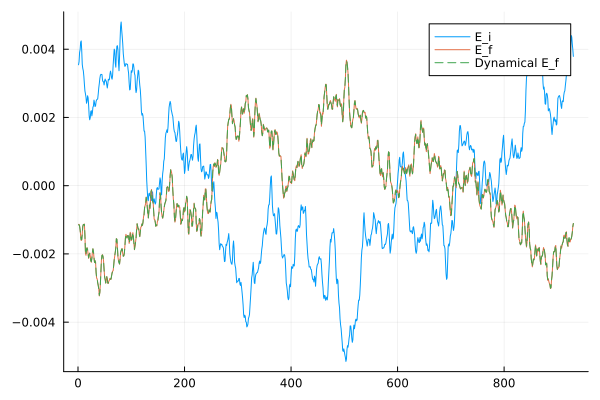

In [22]:
#@bell sleep(3)
E_f = zeros(J)
#ϕ_f = zeros(J)
#n_f = zeros(J) #charge density
if Poisson
    get_density!(u, n, par_grid, 0.0)
    get_ϕ!(ϕ, n .- 1., κ)
    get_E_from_ϕ!(ϕ,E_f,dx)
end
if E_direct
    get_density!(u, n, par_grid, 0.5)
    get_E_direct!(E_f,-n .+ 1.0,par_grid)
end

plot(E_i, label="E_i")
plot!(E_f, label="E_f")
plot!(u[2N+1:end], ls=:dash, label="Dynamical E_f")

Saving the results

In [21]:
if remote_server
    exit() #if running as script
end

In [24]:
rfft(E_i)[nm+1]

0.060145630933730654 + 0.31190415932386045im

## Studying the solutions: 

Post procesing is done in post_pro_landau_rel

### Energy:

34 peaks in T = 100, so $\omega = 0.34$

We save the data:

| time | order | energy | theta |
|------|-------|--------|-------|
|  40  |  1    | 7.4e-7 | 0.009978|
|  40  |  3    | 7.9e-8 | 0.009979 |
|  40  |  5    | 1.1e-7 | 0.009979 |
|  4000|  1    | 7.6e-5 | 0.009978 |
|  4000|  3    | 7.2e-6 | 0.010086 |
|  4000|  5    | 1.0e-5 | 0.010031 |
|  4e6 |  1    | 0.0360 | 0.010119 |
